In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style('ticks', {"axes.linewidth": "1",'axes.yaxis.grid':False})
current_palette = sns.color_palette()

In [2]:
import sys
PATH_ = '/om/user/rishir/lib/MentalPong/behavior/'
sys.path.insert(0, PATH_)

from rnn_analysis import utils, data_utils
import numpy as np
import pickle as pk
import pandas as pd
import BehavioralCharacterizer as BC
from scipy.stats import pearsonr, ttest_rel

figoutpath = '/om/user/rishir/figs/mpong/primates_to_rnn/'

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.set_option('mode.chained_assignment', None)

In [3]:
full_fn = '/om/user/rishir/lib/MentalPong/dat/comparison_full_pred.pkl'
summary_fn = '/om/user/rishir/lib/MentalPong/dat/comparison_summary_pred.pkl'
type_suffix = 'pred'

In [4]:
comparison_full = pk.load(open(full_fn, 'rb'))

def get_mean_behavior(model_dat_fn, metricn, mask_fn='output_f'):
    x = comparison_full.res_model_dat[model_dat_fn][metricn]['mu'][0]
    mask = comparison_full.masks[mask_fn]
    return x[np.isfinite(mask)]

perfs_total, perfs_bias = {}, {}

for fk in ['Humanocc', 'Monkeyocc']:
    yh = get_mean_behavior(fk, 'diff_abs_err_total')
    perfs_total[fk] = np.nanmean((yh))
    yh = get_mean_behavior(fk, 'diff_abs_err_bias')
    perfs_bias[fk] = np.nanmean((yh))

shuffled_null = comparison_full.get_shuffled_null()

In [5]:
print(perfs_total)
print(perfs_bias)
print(shuffled_null)

{'Humanocc': 1.0646512288722045, 'Monkeyocc': 1.8746821738661084}
{'Humanocc': 0.7113586472169348, 'Monkeyocc': 1.2419784173137607}
{'error_f_mae': 6.493819121245172, 'cons_Humanocc_residual_err_total': -0.004817219015124172}


In [6]:
df, df_model, df_primate  = data_utils.load__comparison_summary_df(output_rep='pred')

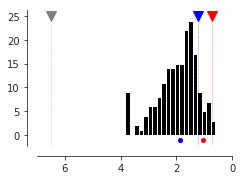

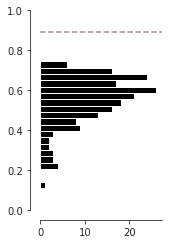

In [9]:
def plot_axvline(ax, xval, yval, color):
    ax.plot(xval, yval, marker='v', color=color, markersize=10)
    ax.axvline(xval, linestyle=':', color=color, linewidth=0.5)
    return
    
df_curr = df_model
perf_data = perfs_bias
metricn1 = 'error_f_mae'
metricn2 = 'cons_Humanocc_residual_err_total'

f,axes = plt.subplots(1,1,figsize=(3.5,2.5))
axes.hist(df_curr[metricn1], 20, color='k')
marker_y_low, marker_y_high = -1, 25
plot_axvline(axes, perfs_bias['Humanocc'], marker_y_high, 'r')
plot_axvline(axes, perfs_bias['Monkeyocc'], marker_y_high, 'b')
plot_axvline(axes, shuffled_null[metricn1], marker_y_high, [0.5, 0.5, 0.5])

axes.plot(perfs_total['Humanocc'], marker_y_low, marker='o', color='r', markersize=4)
axes.plot(perfs_total['Monkeyocc'], marker_y_low, marker='o', color='b', markersize=4)
axes.set_xlim([7,0])
sns.despine(ax=axes, offset=10, trim=False)
f.savefig('%s/performance_dist_%s.pdf' % (figoutpath, type_suffix))

f,axes = plt.subplots(1,1,figsize=(2.5,3.5))
axes.hist(df_curr[metricn2], 20, color='k', orientation="horizontal")
monk2hum_cons = np.nanmean(df_primate.query('name == "Monkeyocc"')[metricn2])
axes.set_ylim([0,1])
axes.axhline(monk2hum_cons, linestyle='--', color=[0.65, 0.56, 0.56])
axes.axhline(shuffled_null[metricn2], linestyle='--', color=[0.5, 0.5, 0.5])

sns.despine(ax=axes, offset=10, trim=False)
plt.tight_layout()
f.savefig('%s/consistency_dist_%s.pdf' % (figoutpath, type_suffix))

In [10]:
def plot_least_square_line(x,y,ax):
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 'k:')
    return

def plot_scatter_vs_consistency(consistency_metrics, predictor_metrics, 
                                suffix='', df_=df_model, flip_x_axis=False):
    for cons_metricn in consistency_metrics:
        for x_metricn in predictor_metrics:
            f,axes = plt.subplots(1,1,figsize=(4,5))
            ax = axes
            sns.scatterplot(data=df_, x=x_metricn, y=cons_metricn,
                            hue="loss_weight_type", style="rnn_type", 
                            ax=ax, legend='brief');

            ax.axhline(np.nanmean(df_primate[cons_metricn]), 
                       linestyle='--', color='k')
            plot_least_square_line(df_[x_metricn], 
                                   df_[cons_metricn], ax)
            ax.set_ylim([0,1])
            M = df_[x_metricn].max()*1.1
            m = df_[x_metricn].min()*0.9
            if flip_x_axis:
                ax.set_xlim([M,m])
            else:
                ax.set_xlim([m,M])                
            sns.despine(ax=ax, offset=10, trim=False)
            plt.tight_layout()
            if suffix is not None:
                f.savefig('%s/scatter_v2_%s_%s_%s.pdf' % (figoutpath, x_metricn, cons_metricn, suffix))
    return f,axes
     
def plot_variance_exp_of_consistency(cons_metrics, predictor_metrics,
                                     square_correlation=True,
                                     suffix='', plot_full_r2=False,
                                     plot_xlabels=False, df_=df_model):
    x_size = np.max([np.min([len(predictor_metrics)*0.33, 12]),5])
    y_size = 5
    if plot_xlabels:
        y_size = 8
    f,axes = plt.subplots(2,1,figsize=(x_size,y_size))
    cols = ['#ff00aa', '#00aaff']

    for ci, cons_metric in enumerate(cons_metrics):
        ax = axes[ci]
        fks = [cons_metric] + predictor_metrics
        df_for_corr = df_[fks]
        rho_raw = df_for_corr.corr()
        if square_correlation:
            r2_raw = rho_raw[cons_metric]**2
        else:
            r2_raw = rho_raw[cons_metric]

        tmp = np.array(df_for_corr)
        rho_partial = utils.partial_corr(tmp, add_offset=True)[0]
        if square_correlation:
            r2_partial = rho_partial**2
        else:
            r2_partial = rho_partial

        plot_vals = [i for i in range(len(fks)) if i!=0]
        ax.bar(plot_vals, r2_raw[plot_vals], width=0.3, color=cols[0])
        ax.bar([i+.3 for i in plot_vals], r2_partial[plot_vals], width=0.3, color=cols[1])
#         print(r2_raw[plot_vals], r2_partial[plot_vals])
        sns.despine(ax=ax, offset=10, trim=False)
        ax.set_title(cons_metric)
        if (ci == len(cons_metrics)-1) and plot_xlabels:
            ax.set_xticks([i+.15 for i in plot_vals])
            ax.set_xticklabels(predictor_metrics, rotation=90)
        
        if plot_full_r2:
            X = np.array(df_[predictor_metrics])
            y = np.array(df_[[cons_metric]])
            r2 = utils.get_R2_highD(y, X, k_folds=20)
            if square_correlation is False:
                r2 = r2 ** 0.5
            ax.axhline(r2, linestyle='--',
                       linewidth=0.5, color=[0.5, 0.5, 0.5])
            print('full r2: %2.2f' % r2)

    plt.tight_layout()
    if suffix is not None:
        f.savefig('%s/consistency_variance_v2_exp_%s.pdf' % (figoutpath, suffix))
    return

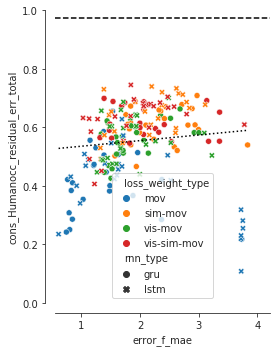

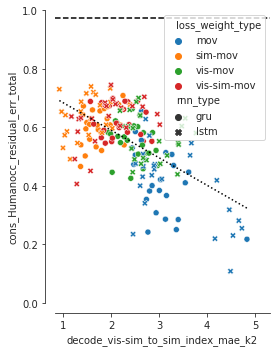

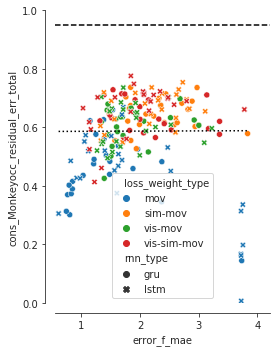

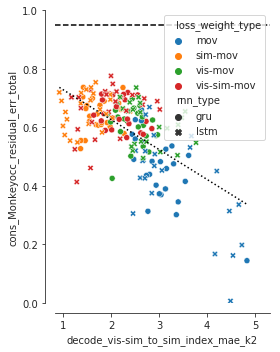

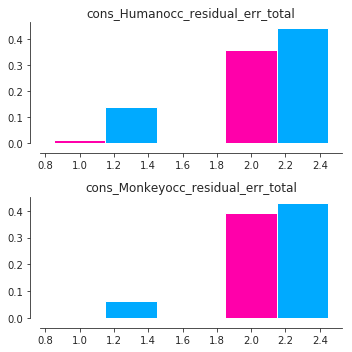

In [11]:
consistency_metrics =[  'cons_Humanocc_residual_err_total', 'cons_Monkeyocc_residual_err_total']
predictor_metrics = [ 'error_f_mae', 'decode_vis-sim_to_sim_index_mae_k2']
suffix = 'functional_%s' % type_suffix
plot_scatter_vs_consistency(consistency_metrics, predictor_metrics, suffix=suffix)
plot_variance_exp_of_consistency(consistency_metrics, predictor_metrics, suffix=suffix)

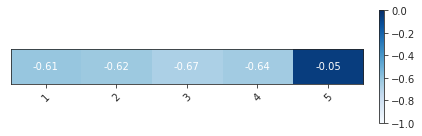

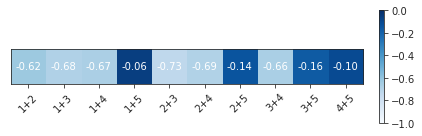

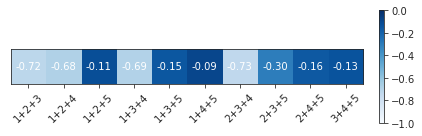

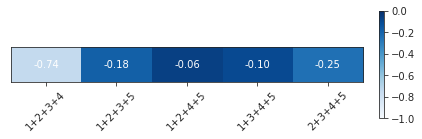

In [12]:
# measure "noise correlations", i.e. correlation between SI and HC after accounting for architectural choices

choices =  ['rnn_type', 'input_representation', 'n_hidden', 'reg', 'loss_weight_type']

def plot_one_noise_corr(df_model_, cv_list, ax, corr_var):
    res_cond_corr_mu, res_cond_corr_med = [], []
    for control_var in cv_list:
        x_df = df_model_.groupby(control_var)[corr_var].corr()
        x_mu = x_df.unstack()[corr_var[0]][corr_var[1]]
        res_cond_corr_mu.append(x_mu.mean())
        res_cond_corr_med.append(x_mu.median())

    colormap = plt.cm.Blues #my_cmap#
    cvi_list_ticks = ["+".join([str(choices.index(cc)+1) for cc in c]) for c in cv_list]

    x = np.array(res_cond_corr_mu)
    im = ax.imshow(np.reshape(x,(x.shape[0],1)).T, cmap=colormap, vmin=-1.0, vmax=0.0,
                 interpolation='none', aspect=x.shape[0]/10.0)#(x.shape[0]**-1))
    for i in range(x.shape[0]):
        text = ax.text(i, 0, '%2.2f'%x[i],
                       ha="center", va="center", color="w")
    ax.set_yticks([])
    ax.set_xticks(range(x.shape[0]))
    ax.set_xticklabels(cvi_list_ticks, rotation=45)
    h = f.colorbar(im,ax=ax, fraction=0.046, pad=0.04)
    return

import itertools
choice_list = []
choice_list_separate = [list(itertools.combinations(choices, i+1)) for i in range(4)]
corr_var = ['cons_Humanocc_residual_err_total', 'decode_vis-sim_to_sim_index_mae_k2']
for i, cv_list_ in enumerate(choice_list_separate):
    f,axes = plt.subplots(1,1,figsize=(6,2))
    cv_list_ = [list(x) for x in cv_list_]
    plot_one_noise_corr(df_model, cv_list_, axes, corr_var)
    plt.tight_layout()
    f.savefig('%s/noise_corr_comb%d.pdf' % (figoutpath, i))


input_representation ['gabor_pca' 'pixel_pca']
loss_weight_type ['mov' 'sim-mov' 'vis-mov' 'vis-sim-mov']
n_hidden [10. 20.]
output_representation ['pred']
reg ['L2_0.01' 'L2_0.1' 'L1_0.01' 'L1_0.1' 'none_0.0']
rnn_type ['gru' 'lstm']


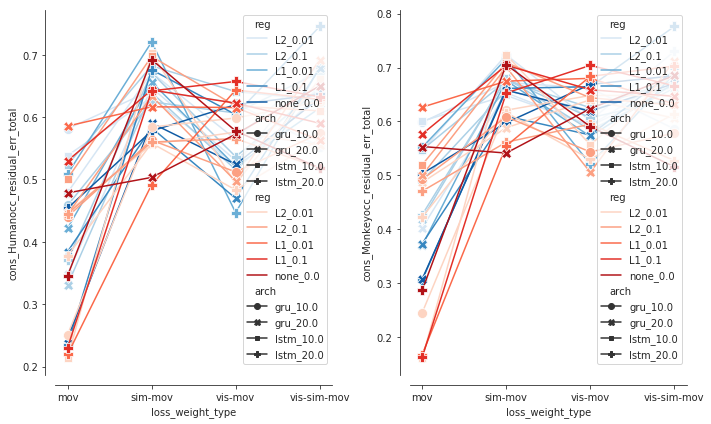

In [13]:
params = ['input_representation', 
          'loss_weight_type', 'n_hidden',
          'output_representation',
          'reg',
         'rnn_type']

for p in params:
    if isinstance(df[p][0], dict):
        continue
    print(p, df[p].unique())
    
df_model1 = df_model.query('input_representation == "pixel_pca"')
df_model2 = df_model.query('input_representation == "gabor_pca"')
f,axes = plt.subplots(1,2,figsize=(10,6))
for fki,fk in enumerate(['cons_Humanocc_residual_err_total', 'cons_Monkeyocc_residual_err_total']):
    sns.lineplot(data=df_model1, x='loss_weight_type', y=fk,
                 hue='reg',style='arch', 
                 palette='Blues', markers=True,
                 dashes=False, markersize=10,
                 ci=None,ax=axes[fki])
    sns.lineplot(data=df_model2, x='loss_weight_type', y=fk,
                 hue='reg',style='arch', 
                 palette='Reds', markers=True,
                 dashes=False, markersize=10,
                 ci=None,ax=axes[fki])
    sns.despine(ax=axes[fki], offset=10, trim=False)
plt.tight_layout()
f.savefig('%s/cons_vs_arch_%s.pdf' % (figoutpath, type_suffix))

input_representation ['gabor_pca' 'pixel_pca']
loss_weight_type ['mov' 'sim-mov' 'vis-mov' 'vis-sim-mov']
n_hidden [10. 20.]
output_representation ['pred']
reg ['L2_0.01' 'L2_0.1' 'L1_0.01' 'L1_0.1' 'none_0.0']
rnn_type ['gru' 'lstm']


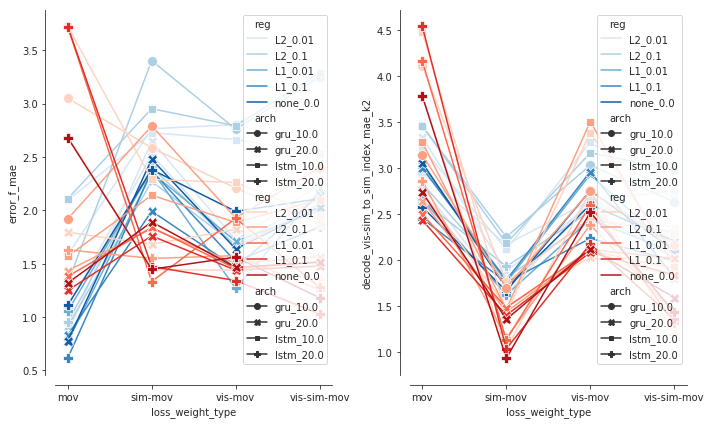

In [14]:
params = ['input_representation', 
          'loss_weight_type', 'n_hidden',
          'output_representation',
          'reg',
         'rnn_type']

for p in params:
    if isinstance(df[p][0], dict):
        continue
    print(p, df[p].unique())
    
df_model1 = df_model.query('input_representation == "pixel_pca"')
df_model2 = df_model.query('input_representation == "gabor_pca"')
f,axes = plt.subplots(1,2,figsize=(10,6))
for fki,fk in enumerate([ 'error_f_mae', 'decode_vis-sim_to_sim_index_mae_k2']):
    sns.lineplot(data=df_model1, x='loss_weight_type', y=fk,
                 hue='reg',style='arch', 
                 palette='Blues', markers=True,
                 dashes=False, markersize=10,
                 ci=None,ax=axes[fki])
    sns.lineplot(data=df_model2, x='loss_weight_type', y=fk,
                 hue='reg',style='arch', 
                 palette='Reds', markers=True,
                 dashes=False, markersize=10,
                 ci=None,ax=axes[fki])
    sns.despine(ax=axes[fki], offset=10, trim=False)
plt.tight_layout()
f.savefig('%s/perf_vs_arch_%s.pdf' % (figoutpath, type_suffix))